In [120]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import time
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

tr_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform)
te_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)

indices = list(range(10000))
tr_subset = Subset(tr_set, indices)
indices = list(range(2000))
te_subset = Subset(te_set, indices)

#Loads the training set
tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Load test set
te_loader = torch.utils.data.DataLoader(te_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


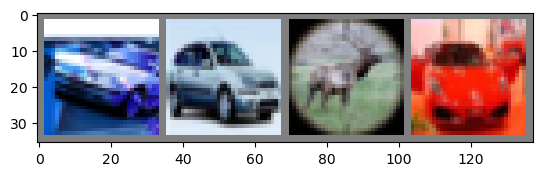

car   car   deer  car  


In [72]:
torch.manual_seed(seed)

#Function displays image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(tr_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Convolutional Neural Network

In [115]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

class ConNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, device, tr_loader, optimizer, criterion, epochs):
        self.train()
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(epochs):
            for X_tr, y_tr in tr_loader:
                X_tr, y_tr = X_tr.to(device), y_tr.to(device)
                optimizer.zero_grad()
                output = self(X_tr)
                loss = criterion(output, y_tr)
                loss.backward()
                optimizer.step()
                
            scheduler.step()

    
    def predict(self, device, loader):
        self.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_te, y_te in loader:
                X_te, y_te = X_te.to(device), y_te.to(device)
                output = self(X_te)
                preds = output.argmax(dim=1, keepdim=True)
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(y_te.cpu().numpy())

        return np.array(all_preds), np.array(all_labels)

    def compute_accuracy(self, y_pre, y_true):
        correct = (y_true == y_pre).sum()
        total = len(y_true)
        return correct / total

cnn = ConNeuralNetwork()

In [117]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn.fit(device, tr_loader, optimizer, criterion, epochs=10)

In [87]:
PATH = './cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

In [124]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn.fit(device, tr_loader, optimizer, criterion, epochs=10)

start_time = time.time()
y_pre, y_true = cnn.predict(device, te_loader)
end_time = time.time()
prediction_time = end_time - start_time
time_per_image = prediction_time / len(te_subset)
print(f"Average prediction time per image: {time_per_image:.6f} seconds")

print("Score is: ", cnn.compute_accuracy(y_pre, y_true))

Average prediction time per image: 0.003561 seconds
Score is:  0.5065


In [132]:
def find_best_epochs(epochs):
    best_epoch = None
    best_accuracy = 0.0

    for epoch in epochs:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        cnn.fit(device, tr_loader, optimizer, criterion, epochs=epoch)

        y_pre, y_true = cnn.predict(device, te_loader)

        accuracy = cnn.compute_accuracy( y_pre, y_true)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = epoch

    return best_epoch

print(find_best_epochs([1,5,10,20,30]))

KeyboardInterrupt: 

In [91]:
def errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes):
    tr_err_cnn = [] # training error for CNN
    te_err_cnn = [] # testing error for CNN

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for size in train_sizes:
        indices = list(range(size))
        tr_subset = Subset(tr_set, indices)
        tr_loader = DataLoader(tr_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        cnn = ConNeuralNetwork().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
        
        # Train model
        cnn.fit(device, tr_loader, optimizer, scheduler, criterion, epochs=10)
        
        # Training error
        y_pred_train, y_true_train = cnn.predict(device, tr_loader)
        train_accuracy = cnn.compute_accuracy(y_pred_train, y_true_train)
        train_error = 1 - train_accuracy
        tr_err_cnn.append(train_error)
        
        # Testing error
        y_pred_test, y_true_test = cnn.predict(device, te_loader)
        test_accuracy = cnn.compute_accuracy(y_pred_test, y_true_test)
        test_error = 1 - test_accuracy
        te_err_cnn.append(test_error)

    return tr_err_cnn, te_err_cnn

In [92]:
def plot_errors_for_train_sizes_cnn(tr_err_cnn, te_err_cnn, train_sizes):

    plt.semilogx(train_sizes, tr_err_cnn, label='tr_cnn', marker='x', color='orange')
    plt.semilogx(train_sizes, te_err_cnn, label='te_cnn', linestyle='--', marker='x', color='orange')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

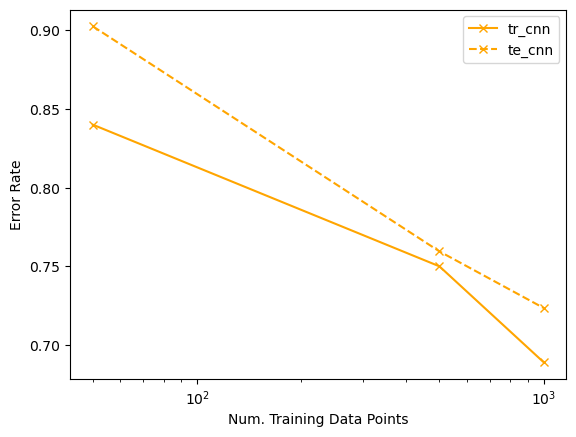

In [27]:
train_sizes = [50, 500, 1000]
tr_err, te_err = errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes)
plot_errors_for_train_sizes_cnn(tr_err, te_err, train_sizes)

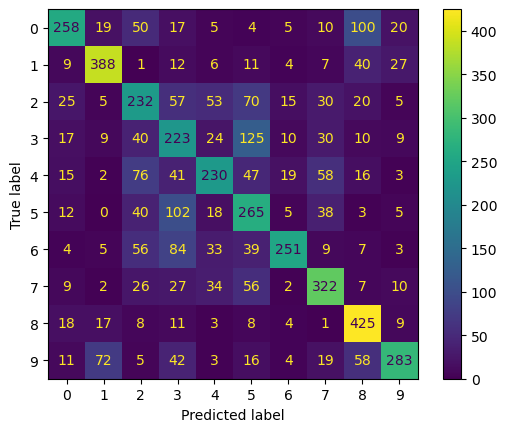

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model):

    # Make predictions on training and testing data
    y_pre, y_te = model.predict(device, te_loader)


    # Evaluate confusion matrix using your function compute_confusion_matrix
    cm = confusion_matrix(y_te, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

plot_confusion_matrix(cnn)

# MLP Classification

In [98]:
X_tr = np.array([tr_set[i][0].numpy() for i in range(len(tr_set))])
y_tr = np.array([tr_set[i][1] for i in range(len(tr_set))])
X_te = np.array([te_set[i][0].numpy() for i in range(len(te_set))])
y_te = np.array([te_set[i][1] for i in range(len(te_set))])


In [99]:
mean_pixel = np.mean(X_tr, axis=(0, 1, 2))
std_pixel = np.std(X_tr, axis=(0, 1, 2))
min_pixel = np.min(X_tr, axis=(0, 1, 2))
max_pixel = np.max(X_tr, axis=(0, 1, 2))

print("Mean normalized pixel values:", mean_pixel)
print("Standard deviation of normalized pixel values:", std_pixel)
print("Minimum normalized pixel values:", min_pixel)
print("Maximum normalized pixel values:", max_pixel)

Mean normalized pixel values: [-0.02206252 -0.0406169  -0.0463728  -0.05144313 -0.05472538 -0.05625335
 -0.05688907 -0.05714419 -0.05710053 -0.05685697 -0.05646389 -0.05660968
 -0.05717352 -0.05749096 -0.05814276 -0.05885128 -0.05890689 -0.0584798
 -0.05783283 -0.05715771 -0.05717792 -0.05719506 -0.05693044 -0.05661761
 -0.05669537 -0.0562898  -0.05605028 -0.05513093 -0.05241487 -0.04817131
 -0.0422875  -0.03172589]
Standard deviation of normalized pixel values: [0.5277244  0.5168944  0.51166594 0.50817966 0.50474596 0.5030011
 0.50025326 0.49946505 0.49738276 0.49654627 0.49538493 0.49517485
 0.49409014 0.49356443 0.49302414 0.49327558 0.49322405 0.49340874
 0.49391437 0.49465865 0.49617618 0.4961314  0.49740633 0.4979996
 0.49993607 0.50099    0.50395334 0.5055563  0.5085286  0.51147085
 0.51505154 0.5227425 ]
Minimum normalized pixel values: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Maximum norm

In [100]:

def reshape_data(X_tr, X_te):

    X_tr_shaped = X_tr.reshape(X_tr.shape[0], -1)
    X_te_shaped = X_te.reshape(X_te.shape[0], -1)

    return X_tr_shaped, X_te_shaped

X_tr_shaped, X_te_shaped = reshape_data(X_tr, X_te)
print(X_tr_shaped, X_te_shaped)

[[-0.5372549  -0.6627451  -0.60784316 ...  0.09803927 -0.34117645
  -0.4352941 ]
 [ 0.20784318 -0.01176471 -0.17647058 ...  0.09019613  0.11372554
   0.12941182]
 [ 1.          0.9843137   0.9843137  ... -0.3490196  -0.3490196
  -0.34117645]
 ...
 [-0.7254902  -0.6862745  -0.67058825 ... -0.3960784  -0.4823529
  -0.60784316]
 [ 0.48235297  0.45882356  0.45098042 ...  0.32549024  0.3411765
   0.3411765 ]
 [ 0.79607844  0.8509804   0.8352941  ...  0.35686278  0.27058828
   0.26274514]] [[ 0.23921573  0.24705887  0.2941177  ... -0.02745098  0.01176476
  -0.1372549 ]
 [ 0.84313726  0.8117647   0.81960785 ...  0.39607847  0.49803925
   0.56078434]
 [ 0.23921573  0.23921573  0.09019613 ... -0.9372549  -0.9764706
  -0.94509804]
 ...
 [-0.84313726 -0.8509804  -0.88235295 ... -0.60784316 -0.58431375
  -0.6313726 ]
 [-0.8039216  -0.88235295 -0.81960785 ... -0.372549   -0.36470586
  -0.372549  ]
 [-0.42745095 -0.23137254 -0.2235294  ... -0.26274508 -0.54509807
  -0.79607844]]


In [106]:
from sklearn.neural_network import MLPClassifier

def errors_for_train_sizes_mlp(X_tr, y_tr, X_te, y_te, seed, train_sizes):
    # append error rates to the following lists
    tr_err_mlp = [] # training error rates for MLP
    te_err_mlp = [] # testing error rates for MLP

    for size in train_sizes:
        X_tr_subset = X_tr[:size]
        y_tr_subset = y_tr[:size]

        mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='adam', learning_rate_init=0.001, batch_size=128, random_state=seed, max_iter=1000)
        mlp.fit(X_tr_subset, y_tr_subset)

        tr_err_mlp.append(1-mlp.score(X_tr_subset, y_tr_subset))
        te_err_mlp.append(1-mlp.score(X_te, y_te))
   
    return tr_err_mlp, te_err_mlp

In [102]:
def plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes):

    plt.semilogx(train_sizes, tr_err_mlp, label='tr_mlp', marker='x', color='orange')
    plt.semilogx(train_sizes, te_err_mlp, label='te_mlp', linestyle='--', marker='x', color='orange')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\si

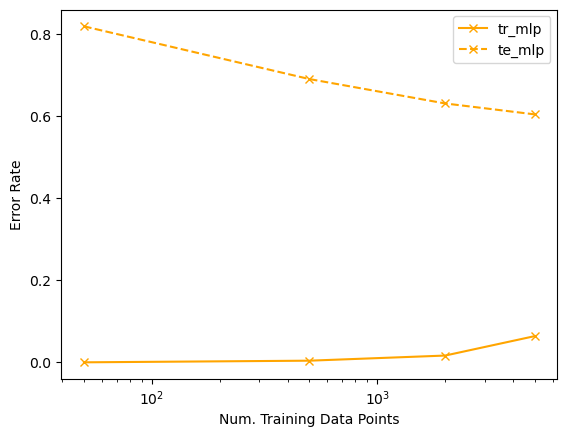

In [107]:
train_sizes = [50, 500, 2000, 5000]
tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_tr_shaped, y_tr, X_te_shaped, y_te, seed, train_sizes)
plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes)

In [125]:

mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='adam', learning_rate_init=0.001, batch_size=128, random_state=seed, max_iter=1000)
mlp.fit(X_tr_shaped[:10000], y_tr[:10000])
start_time = time.time()
predictions = mlp.predict(X_te_shaped[:2000])
end_time = time.time()

prediction_time = end_time - start_time
time_per_image = prediction_time / len(X_te_shaped[:2000])
print(f"Average prediction time per image: {time_per_image:.6f} seconds")
print("Score is: ", mlp.score(X_te_shaped[:2000], y_te[:2000]))

Average prediction time per image: 0.000009 seconds
Score is:  0.409


c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


10000 0.3485


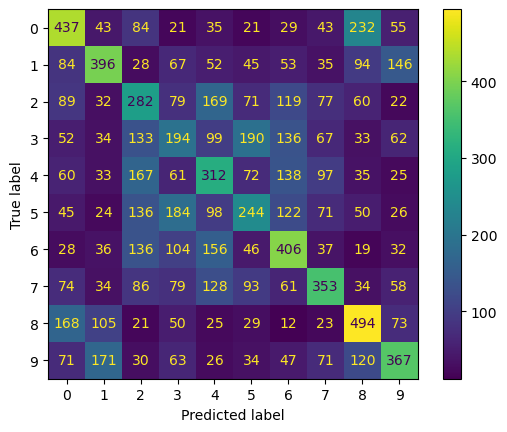

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model):

    # Make predictions on training and testing data
    y_pre = model.predict(X_te_shaped)
    print(len(X_te_shaped), model.score(X_te_shaped, y_te))


    # Evaluate confusion matrix using your function compute_confusion_matrix
    cm = confusion_matrix(y_te, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

plot_confusion_matrix(mlp)

In [129]:
X_tr_b = np.array([tr_subset[i][0].numpy() for i in range(len(tr_subset))])
y_tr_b = np.array([tr_subset[i][1] for i in range(len(tr_subset))])
X_te_b = np.array([te_subset[i][0].numpy() for i in range(len(te_subset))])
y_te_b = np.array([te_subset[i][1] for i in range(len(te_subset))])

X_tr_b, X_te_b = reshape_data(X_tr_b, X_te_b)

def find_best_batch_size(X_tr, y_tr, X_te, y_te, batch_sizes, seed):
    best_batch_size = None
    best_accuracy = 0.0
    
    for batch_size in batch_sizes:
        mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='adam', learning_rate_init=0.001, batch_size=batch_size, random_state=seed, max_iter=1000)
        
        mlp.fit(X_tr, y_tr)
    
        y_te_pred = mlp.predict(X_te)
        accuracy = accuracy_score(y_te, y_te_pred)
        
        print(f"Batch Size: {batch_size}, Accuracy: {accuracy}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_batch_size = batch_size
    
    print(f"Best Batch Size: {best_batch_size}, Best Accuracy: {best_accuracy}")
    return best_batch_size

batch_sizes = [32, 64, 128, 256]
find_best_batch_size(X_tr_b[:10000], y_tr_b[:10000], X_te_b[:2000], y_te_b[:2000], batch_sizes, seed)


Batch Size: 32, Accuracy: 0.3955
Batch Size: 64, Accuracy: 0.396
Batch Size: 128, Accuracy: 0.3965
Batch Size: 256, Accuracy: 0.3925
Best Batch Size: 128, Best Accuracy: 0.3965


128